<a href="https://colab.research.google.com/github/Ujwal-EVA/Assignment-7/blob/main/EVA3_Session_7_Batch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Dataset - Creating Train/Test Split

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Data Statistics - how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


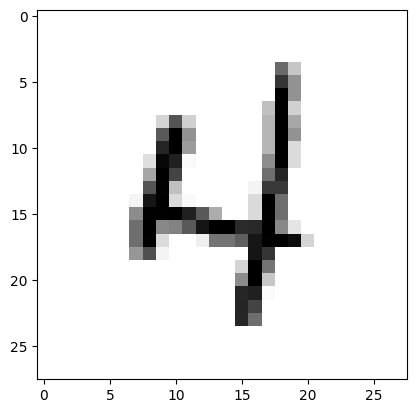

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


The Raw Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Running Epoch & Plotting Results

EPOCH: 0


Loss=0.05313069000840187 Batch_id=468 Accuracy=88.05: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]



Test set: Average loss: 0.0628, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.02042764611542225 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]



Test set: Average loss: 0.0361, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.04018183425068855 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.0341, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.0044920011423528194 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0282, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.010610590688884258 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.0272, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.007351455744355917 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.0267, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.058473870158195496 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0269, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.030956782400608063 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.004966859705746174 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.0337, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.0005093664512969553 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0272, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.0017390175489708781 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.0268, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.00015981447359081358 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]



Test set: Average loss: 0.0310, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=6.864749593660235e-06 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]



Test set: Average loss: 0.0305, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.021811040118336678 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]



Test set: Average loss: 0.0477, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.00014761695638298988 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0371, Accuracy: 9910/10000 (99.10%)

EPOCH: 15


Loss=4.9039936129702255e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0295, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=1.2793566384061705e-05 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]



Test set: Average loss: 0.0327, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.0002018915256485343 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0313, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.0009028720669448376 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0330, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=1.4901134193223697e-07 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]



Test set: Average loss: 0.0332, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

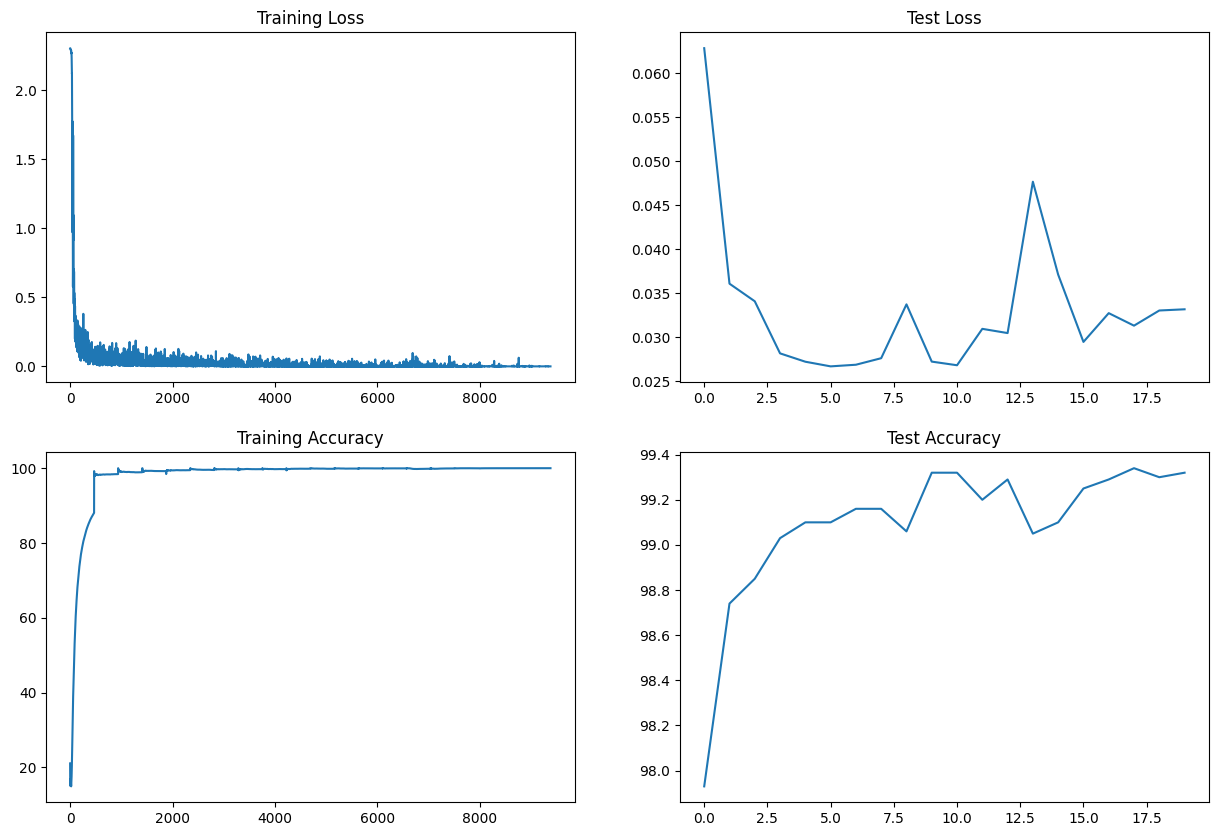

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

train_losses
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")